In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile


import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from transformers import pipeline
import torch

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model


from wordcloud import WordCloud

nltk.download('stopwords', download_dir='/kaggle/working/nltk_data')
nltk.download('punkt', download_dir='/kaggle/working/nltk_data')
nltk.download('wordnet', download_dir='/kaggle/working/nltk_data')
nltk.download('omw-1.4', download_dir='/kaggle/working/nltk_data')
nltk.data.path.append('/kaggle/working/nltk_data')


[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /kaggle/working/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...


In [2]:
nltk_data_path = '/kaggle/working/nltk_data/corpora'
zip_file_path = os.path.join(nltk_data_path, 'wordnet.zip')


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(nltk_data_path)

print("Extraction complete.")

Extraction complete.


In [3]:
data = pd.read_csv('/kaggle/input/air-france-reviews-dataset/airfrance_tripadvisor_reviews.csv')

# First look on the data

Checking if theire is any NaN, duplicates, type etc...

In [4]:
data.head(3)

,rating,title,text,publishedDate
0,1,WORST AIRLINE,I travel a lot - and I travel often. Last week...,2024-11-13
1,1,Terrible experience with Airfrance,"This review is regarding flight AF185, we book...",2024-11-13
2,1,Extremely Disappointing Experience with Air Fr...,I recently flew with Air France on flight #185...,2024-11-12


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         2560 non-null   int64 
 1   title          2560 non-null   object
 2   text           2560 non-null   object
 3   publishedDate  2560 non-null   object
dtypes: int64(1), object(3)
memory usage: 80.1+ KB


In [6]:
data.isnull().mean()*100

rating           0.0
title            0.0
text             0.0
publishedDate    0.0
dtype: float64

In [7]:
data.duplicated().sum()

0

## Ratings 

In [8]:
data['rating'].value_counts()

rating
5    651
1    645
4    580
3    415
2    269
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


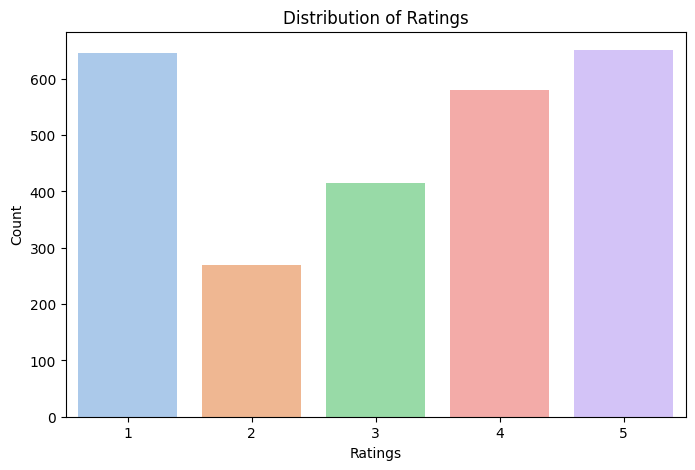

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=data, palette="pastel")
plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

## Date 

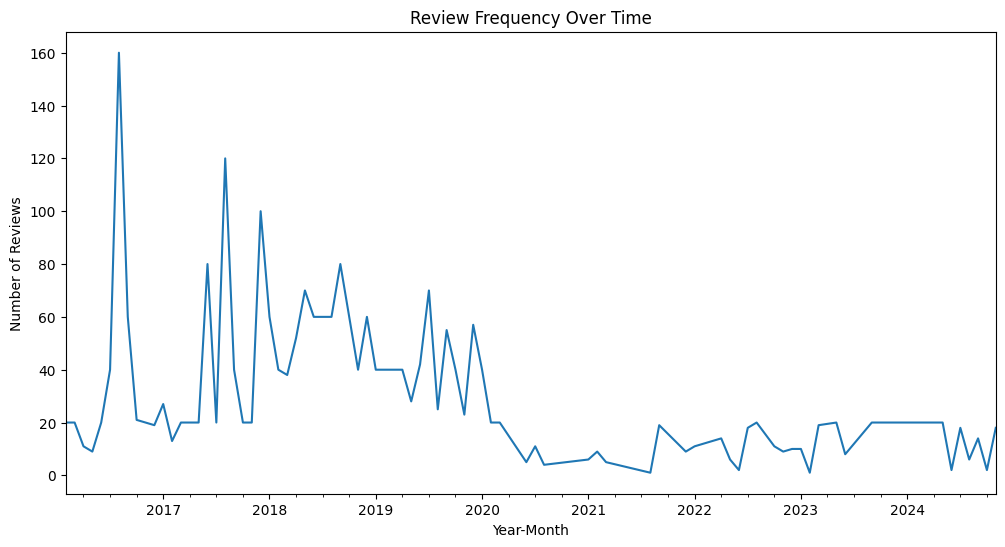

In [10]:
data['publishedDate'] = pd.to_datetime(data['publishedDate'], errors='coerce')
data['year_month'] = data['publishedDate'].dt.to_period('M')

plt.figure(figsize=(12, 6))
data['year_month'].value_counts().sort_index().plot(kind='line')
plt.title("Review Frequency Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Reviews")
plt.show()

# Processing data for a clean text 

In [11]:
def preprocess_text(text):
    if pd.isnull(text):
        return ""

    text = re.sub(r"[^a-zA-Z\s]", "", text)

    text = text.lower()

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)


In [12]:
data['cleaned_text'] = data['text'].apply(preprocess_text)
data.head(3)

,rating,title,text,publishedDate,year_month,cleaned_text
0,1,WORST AIRLINE,I travel a lot - and I travel often. Last week...,2024-11-13,2024-11,travel lot travel often last week flew texas u...
1,1,Terrible experience with Airfrance,"This review is regarding flight AF185, we book...",2024-11-13,2024-11,review regarding flight af booked economy flex...
2,1,Extremely Disappointing Experience with Air Fr...,I recently flew with Air France on flight #185...,2024-11-12,2024-11,recently flew air france flight hong kong pari...


# Sentiment Analysis! 

In [13]:
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [14]:
device = 0 if torch.cuda.is_available() else -1  
# sentiment analyzer Positif, Neutral , Negatif 
analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment",device=device)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
def analyze_sentiment(text):
    if pd.isnull(text) or text.strip() == "":
        return "Neutral"
    result = analyzer(text[:1024])  
    label = result[0]['label']
    

    sentiment_map = {
        'LABEL_0': 'Negative',
        'LABEL_1': 'Neutral',
        'LABEL_2': 'Positive'
    }
    return sentiment_map[label]


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


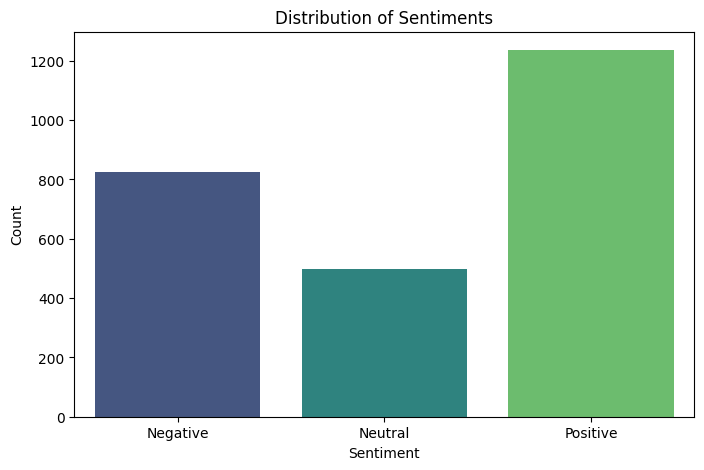

In [16]:
data['sentiment'] = data['cleaned_text'].apply(analyze_sentiment)

plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=data, palette="viridis")
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

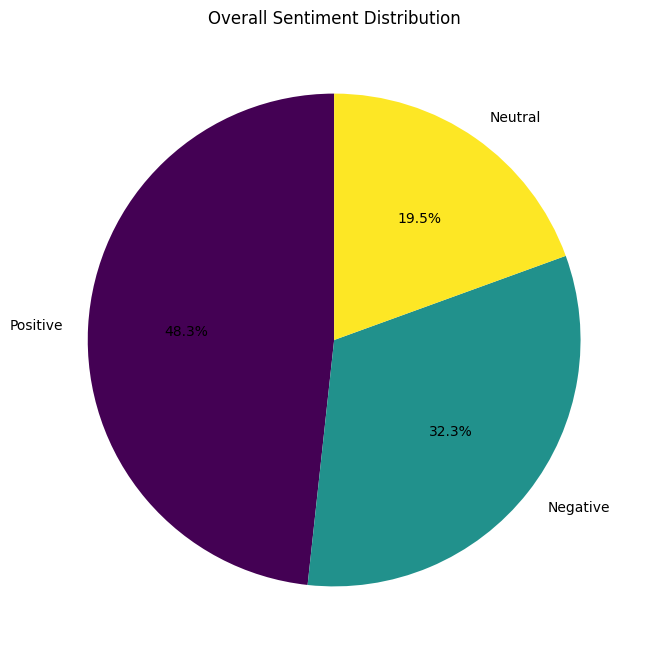

In [17]:
sentiment_counts = data['sentiment'].value_counts()
plt.figure(figsize=(8, 8))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='viridis')
plt.title("Overall Sentiment Distribution")
plt.ylabel("")  
plt.show()

In [18]:
negative = data[data['sentiment'] == 'Negative'].reset_index(drop = True)
neutral = data[data['sentiment'] == 'Neutral'].reset_index(drop = True)
positive = data[data['sentiment'] == 'Positive'].reset_index(drop = True)

In [19]:
negative['title'][0:10]

0                                        WORST AIRLINE
1                   Terrible experience with Airfrance
2    Extremely Disappointing Experience with Air Fr...
3                                             Horrible
4            The Worst Flight Experience I’ve Ever Had
5                       Really cheap flight experience
6    Terrible Customer Service and Duplicate Baggag...
7                                            Nightmare
8    Not the Air France I remember from previous years
9                        Avoid AirFrance at all costs.
Name: title, dtype: object

In [20]:
neutral['title'][0:10]

0    Be Mindful of your Carry-On baggage Weight and...
1                            Terrible customer service
2                                          Horror show
3    Poor aircraft cleanliness, broken facilities a...
4                            Terrible customer service
5                                                  Bad
6    Comfy Seating, but Skimpy Carry-On Weight Limits.
7                Air France are good and quite stable!
8    Separated people in the same family sitting ne...
9                                   Worst airline ever
Name: title, dtype: object

In [21]:
positive['title'][0:10]

0                           Pleasantly supervised.....
1                One of the best airlines in the world
2    Legroom and seats are as small as Spirit or Un...
3      pro con advice my "visit" from CDG to IAD on AF
4                                    Great Great great
5                            Air France Contact Number
6               Great airline with impeccable service!
7                SHORT FLIGHT, GOOED EXPERIENCE THOUGH
8                                    A relaxing flight
9                                        Helpful staff
Name: title, dtype: object

# Topic name determination !

In [22]:
# Function Used for this section !
def compute_coherence_values(vectorizer, data_vectorized, start, stop, step):
    coherence_values = []
    for n_topics in range(start, stop, step):
        lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda_model.fit(data_vectorized)
        coherence_values.append(lda_model.score(data_vectorized))
        
    
    x = range(start, stop, step)
    plt.plot(x, coherence_values, marker='o')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Score for Different Number of Topics")
    plt.show()

def compute_perplexity_values(vectorizer, data_vectorized, start, stop, step):
    perplexity_values = []
    for n_topics in range(start, stop, step):
        lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda_model.fit(data_vectorized)
        perplexity_values.append(lda_model.perplexity(data_vectorized))

    x = range(start, stop, step)
    plt.plot(x, perplexity_values, marker='o', color='red')
    plt.xlabel("Number of Topics")
    plt.ylabel("Perplexity")
    plt.title("Perplexity Score for Different Number of Topics")
    plt.show()


def display_topics(model, feature_names, num_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

def plot_wordcloud_for_topics(lda_model, feature_names, num_topics):
    for topic_idx, topic in enumerate(lda_model.components_):
        plt.figure(figsize=(8, 6))
        wordcloud = WordCloud(
            background_color='white',
            max_words=50
        ).generate(" ".join([feature_names[i] for i in topic.argsort()[:-50 - 1:-1]]))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {topic_idx}")
        plt.show()


def get_words(model, feature, num_words=20):
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[idx] = " ".join([feature[i] for i in topic.argsort()[:-num_words - 1:-1]])
    return topics

def barplot_for_words_in_topics(topics):
    for idx, words in topics.items():
        word_list = words.split()
        counts = np.linspace(1, len(word_list), len(word_list))  # Example counts (use real word scores if available)
        plt.figure(figsize=(10, 6))
        plt.bar(word_list, counts, color='skyblue')
        plt.title(f"Top Words in Topic {idx}")
        plt.xlabel("Words")
        plt.ylabel("Relative Importance")
        plt.xticks(rotation=45)
        plt.show()

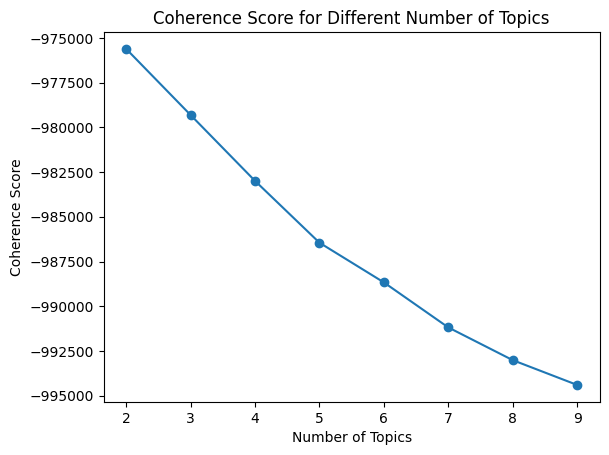

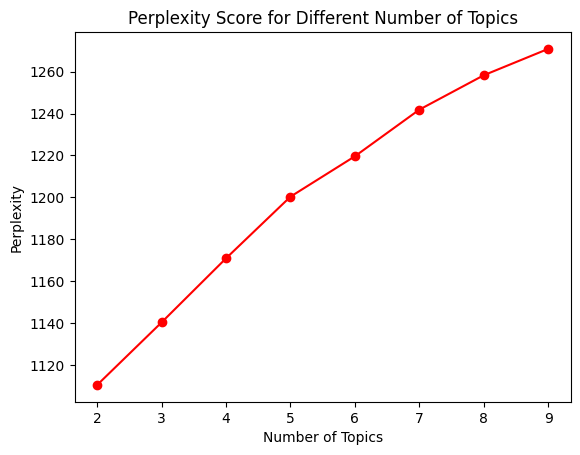

In [23]:
countvectorizer = CountVectorizer(max_features=5000)
data_countvectorized = countvectorizer.fit_transform(data['cleaned_text'])


start, stop, step = 2, 10, 1

compute_coherence_values(countvectorizer, data_countvectorized, start, stop, step)
compute_perplexity_values(countvectorizer, data_countvectorized, start, stop, step)

In [24]:
num_topics = 2
vectorizer = CountVectorizer(
    max_df=0.95,  
    min_df=2,    
    stop_words='english'
)

bow_matrix = vectorizer.fit_transform(data['cleaned_text'])


lda_model = LatentDirichletAllocation(
    n_components=num_topics,
    random_state=42,
    learning_method='batch',
    max_iter=20
)

topic_matrix = lda_model.fit_transform(bow_matrix)

In [25]:
num_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, num_words)

Topic 0:
flight air france paris hour time airport luggage day bag
Topic 1:
flight seat food air good france service time class economy


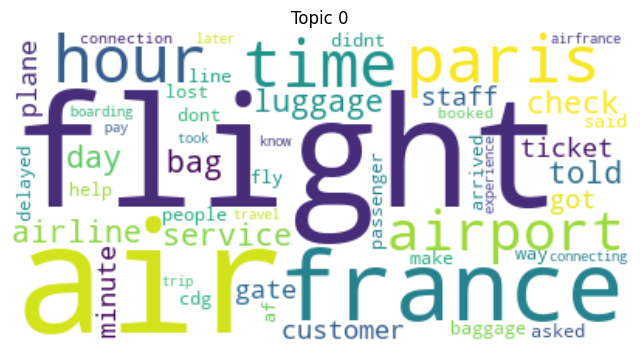

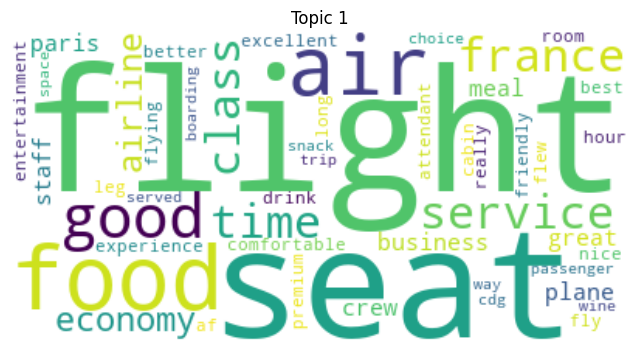

In [26]:
plot_wordcloud_for_topics(lda_model, vectorizer.get_feature_names_out(), num_topics)

In [27]:
#lda_vis = pyLDAvis.lda_model.prepare(lda_model, bow_matrix, vectorizer)
#pyLDAvis.save_html(lda_vis, "lda_visualization.html")

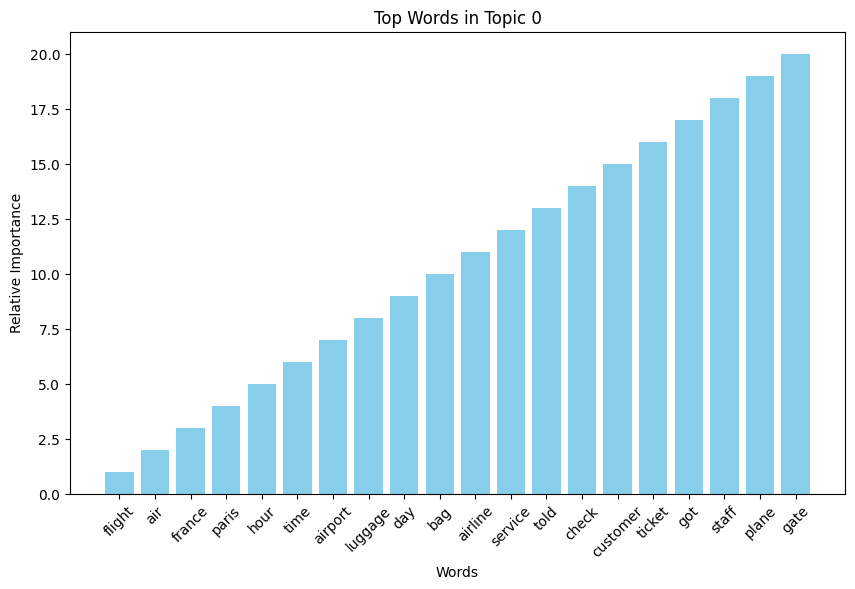

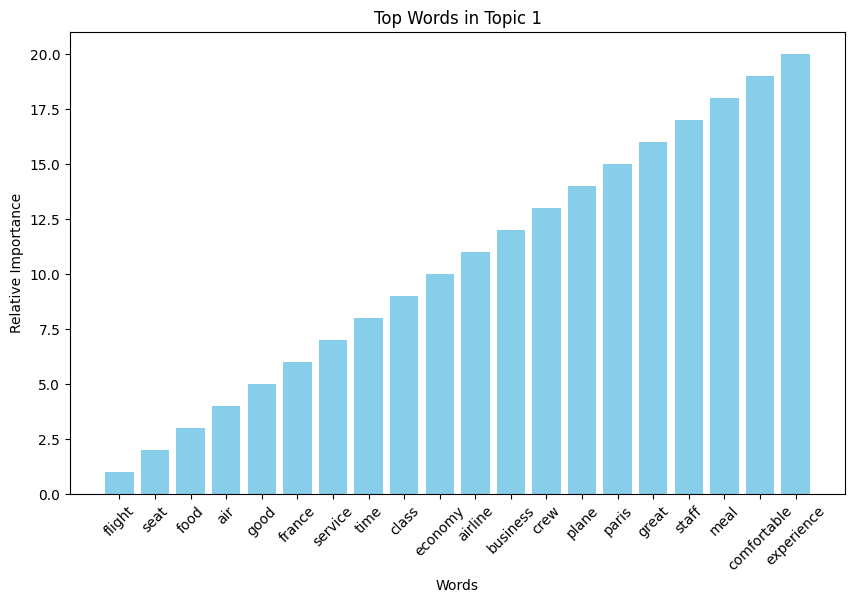

In [29]:
data['topic'] = np.argmax(topic_matrix, axis=1)
topics = get_words(lda_model, vectorizer.get_feature_names_out())
data['topic_words'] = data['topic'].map(topics)
barplot_for_words_in_topics(topics)

In [30]:
# Naming topics 
topic_names = {
    0: 'Travel Experience and Logistics',
    1: 'Flight Comfort and Food'
}

data['topic_name'] = data['topic'].map(topic_names)

#  Visualization 

In [31]:
topic_sentiment = data.groupby(['sentiment', 'topic_name']).size().unstack(fill_value=0)
topic_sentiment

topic_name,Flight Comfort and Food,Travel Experience and Logistics
sentiment,,
Negative,269,557
Neutral,238,260
Positive,1060,176


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

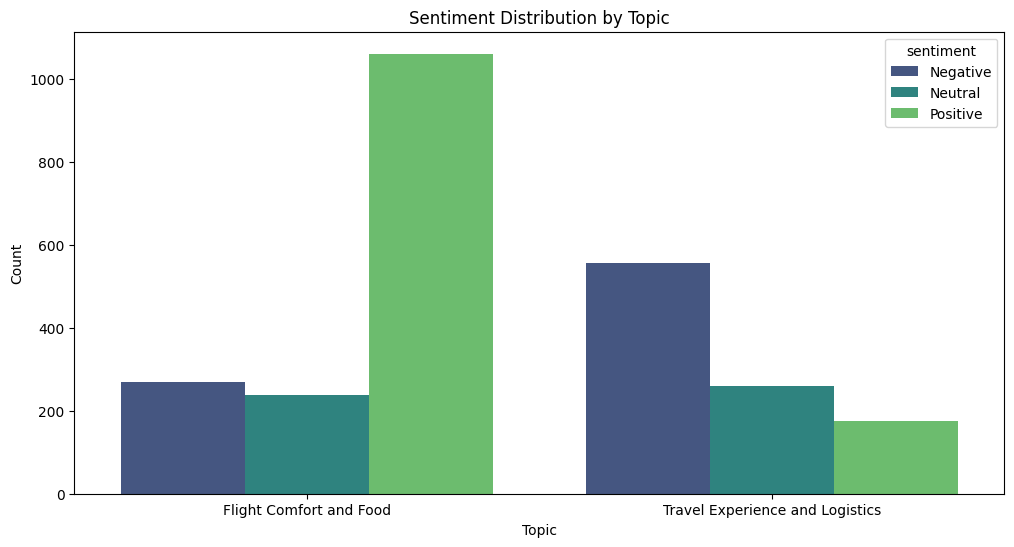

In [32]:
topic_sentiment.reset_index(inplace=True)
topic_sentiment = topic_sentiment.melt(id_vars=['sentiment'], var_name='topic_name', value_name='count')


plt.figure(figsize=(12, 6))
sns.barplot(data=topic_sentiment, x='topic_name', y='count', hue='sentiment', palette='viridis')
plt.title("Sentiment Distribution by Topic")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.show()

<Figure size 1000x600 with 0 Axes>

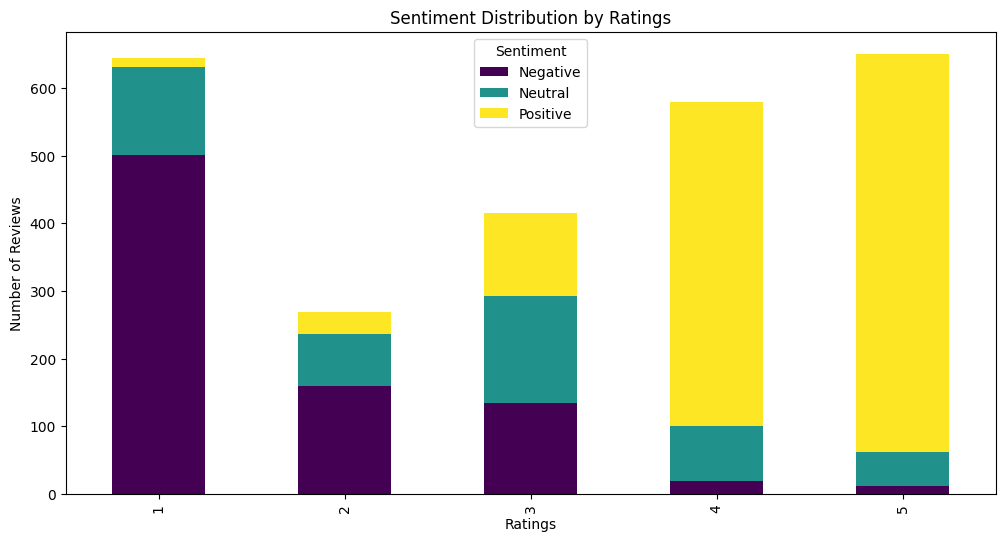

In [33]:
rating_sentiment = data.groupby(['rating', 'sentiment']).size().unstack(fill_value=0)


plt.figure(figsize=(10, 6))
rating_sentiment.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title("Sentiment Distribution by Ratings")
plt.xlabel("Ratings")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.show()

<Figure size 1000x600 with 0 Axes>

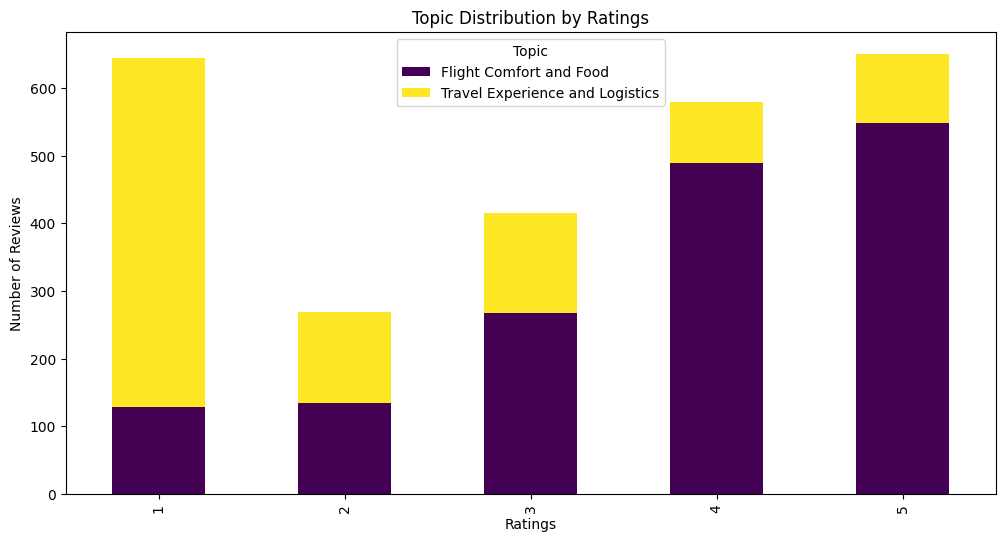

In [34]:
rating_topic = data.groupby(['rating', 'topic_name']).size().unstack(fill_value=0)


plt.figure(figsize=(10, 6))
rating_topic.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title("Topic Distribution by Ratings")
plt.xlabel("Ratings")
plt.ylabel("Number of Reviews")
plt.legend(title="Topic")
plt.show()

<Figure size 1200x800 with 0 Axes>

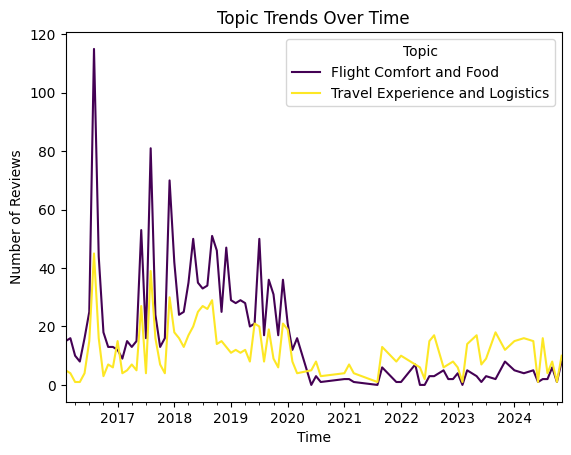

In [35]:
topic_trend = data.groupby(['year_month', 'topic_name']).size().unstack(fill_value=0)


plt.figure(figsize=(12, 8))
topic_trend.plot(kind='line', colormap='viridis')
plt.title("Topic Trends Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Reviews")
plt.legend(title="Topic")
plt.show()

<Figure size 1200x800 with 0 Axes>

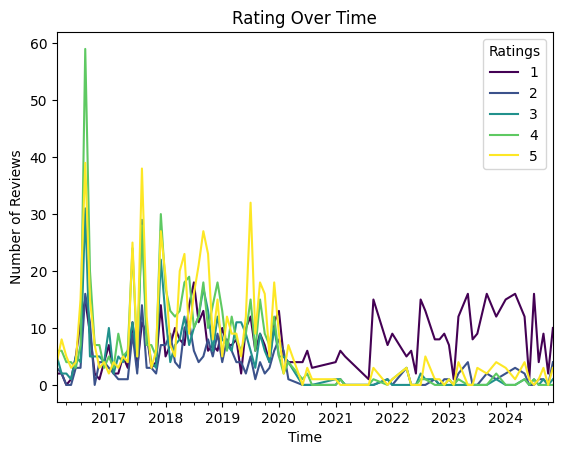

In [36]:
topic_trend = data.groupby(['year_month', 'rating']).size().unstack(fill_value=0)


plt.figure(figsize=(12, 8))
topic_trend.plot(kind='line', colormap='viridis')
plt.title("Rating Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Reviews")
plt.legend(title="Ratings")
plt.show()

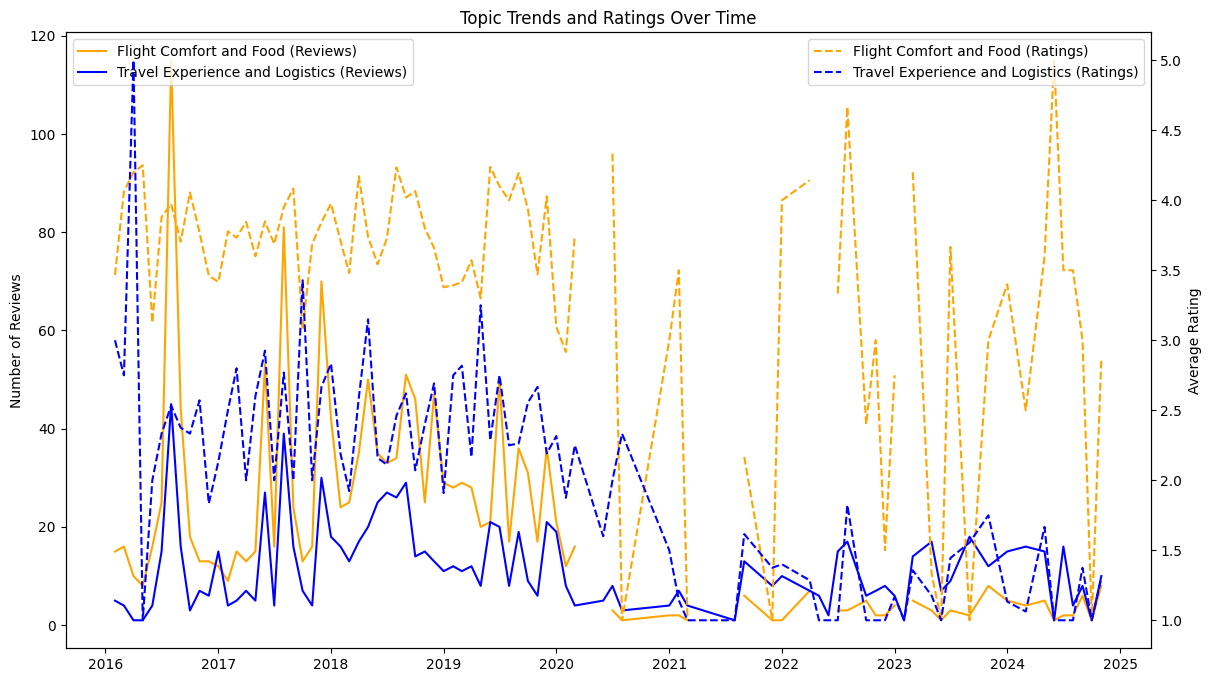

In [38]:
topic_trend_ratings = data.groupby(['year_month', 'topic_name']).agg(
    review_count=('rating', 'size'), 
    avg_rating=('rating', 'mean')   
).reset_index()

pivot_count = topic_trend_ratings.pivot(index='year_month', columns='topic_name', values='review_count')
pivot_avg_rating = topic_trend_ratings.pivot(index='year_month', columns='topic_name', values='avg_rating')

pivot_count.index = pivot_count.index.to_timestamp()
pivot_avg_rating.index = pivot_avg_rating.index.to_timestamp()


color_palette = {
    'Travel Experience and Logistics': 'blue',
    'Flight Comfort and Food': 'orange',
}


fig, ax1 = plt.subplots(figsize=(14, 8))


for topic in pivot_count.columns:
    ax1.plot(
        pivot_count.index, 
        pivot_count[topic], 
        label=f'{topic} (Reviews)', 
        color=color_palette[topic]
    )

ax1.set_ylabel('Number of Reviews')
ax1.set_title('Topic Trends and Ratings Over Time')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
for topic in pivot_avg_rating.columns:
    ax2.plot(
        pivot_avg_rating.index, 
        pivot_avg_rating[topic], 
        label=f'{topic} (Ratings)', 
        color=color_palette[topic],
        linestyle='--'
    )

ax2.set_ylabel('Average Rating')
ax2.legend(loc='upper right')

plt.xlabel('Time')
plt.show()

# Thank you and upvote if you like the work ! :D 